# **Emotion Detector**

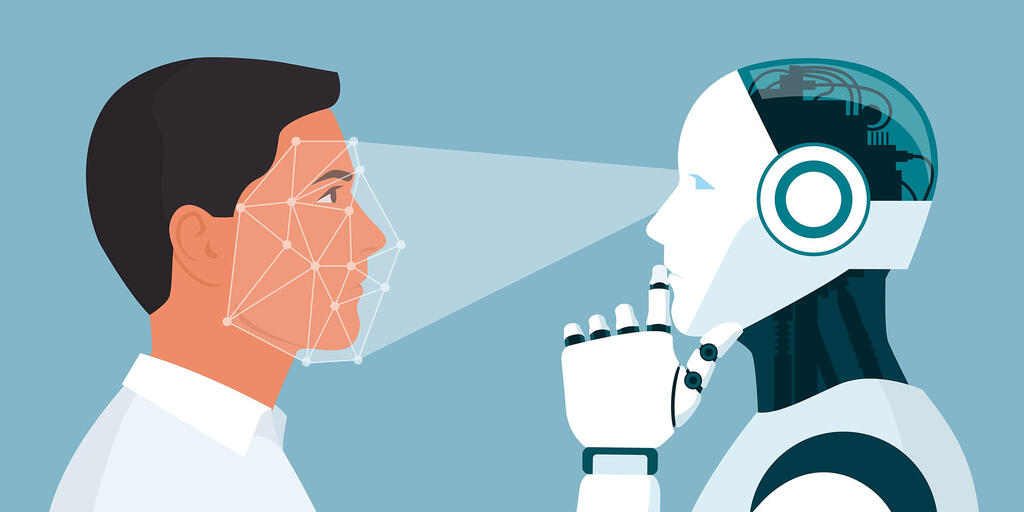

### **Importing Libraries** :

In [ ]:
# Data handling and image processing libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

# For image processing and data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

# For TensorFlow/Keras Model Building
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

# For performance evaluation
from sklearn.metrics import classification_report, confusion_matrix

# If using Google Colab to access Kaggle datasets
from google.colab import files
import shutil


## **Data Collection** :

In [ ]:
!mv "/content/kaggle (5).json" /content/kaggle.json


In [ ]:
import os

# Create the .kaggle directory if it doesn't exist
os.makedirs("/root/.kaggle", exist_ok=True)

# Move the kaggle.json file to the .kaggle directory
!cp /content/kaggle.json /root/.kaggle/

# Set file permissions
!chmod 600 /root/.kaggle/kaggle.json


In [ ]:
!pip install -q kaggle


## **Download The Data**

In [ ]:
!kaggle datasets download -d ananthu017/emotion-detection-fer


Dataset URL: https://www.kaggle.com/datasets/ananthu017/emotion-detection-fer
License(s): CC0-1.0


## **Unzip The Data**

In [ ]:
import zipfile

# Replace this with the correct ZIP file for your dataset
zip_ref = zipfile.ZipFile('/content/emotion-detection-fer.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()


## **Check the Extracted Files** :

In [ ]:
import os

# List files in the extracted directory
extracted_files = os.listdir('/content')
print(extracted_files)


['.config', 'kaggle.json', 'emotion-detection-fer.zip', '.ipynb_checkpoints', 'test', 'train', 'sample_data']


## **Data Visualization**

## **Visualizing the Class Distribution**

<ipython-input-21-6135455888ab>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=emotion_classes, y=emotion_counts, palette='viridis')


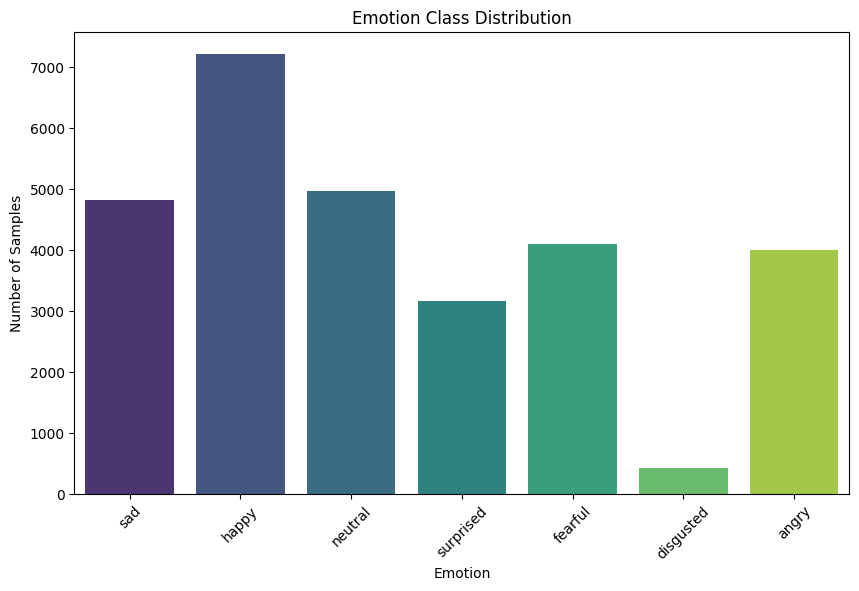

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Set the path to the directory containing the emotion folders
image_dir = '/content/train'  # Adjust the path accordingly

# Get the class names (folder names)
emotion_classes = os.listdir(image_dir)

# Count the number of images in each emotion folder
emotion_counts = [len(os.listdir(os.path.join(image_dir, emotion))) for emotion in emotion_classes]

# Plot the class distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=emotion_classes, y=emotion_counts, palette='viridis')
plt.title('Emotion Class Distribution')
plt.xlabel('Emotion')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.show()


## **Visualizing Sample Images**

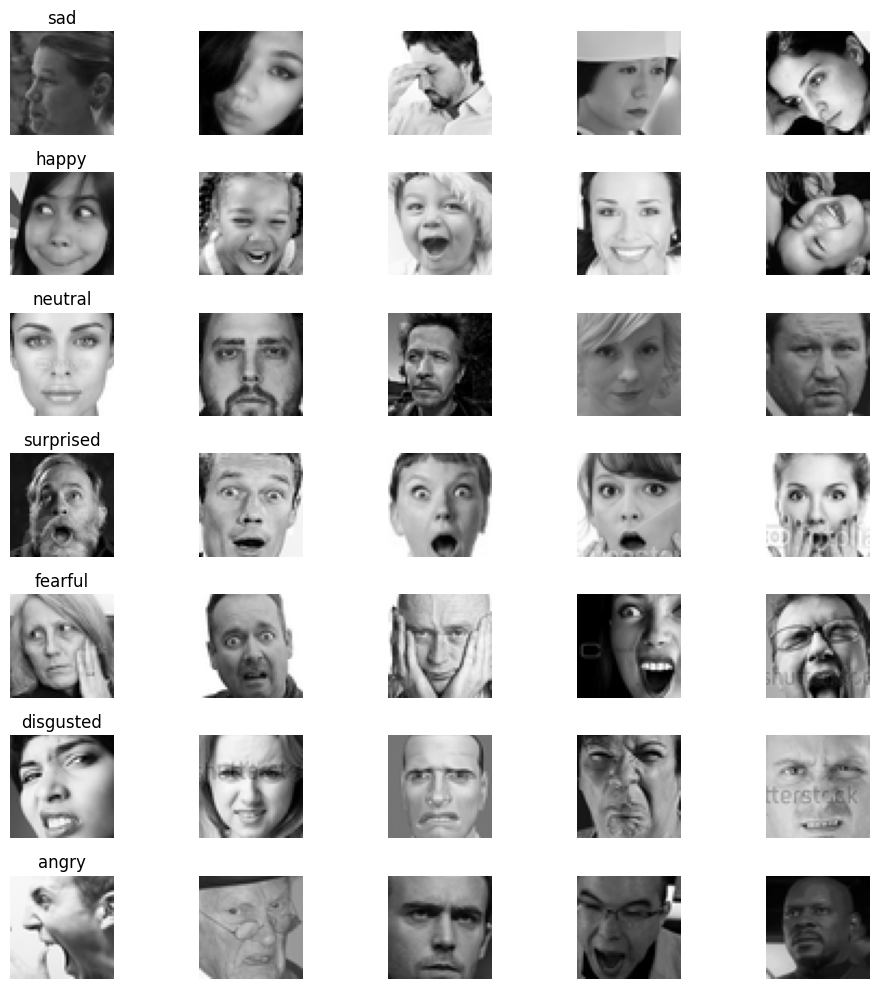

In [ ]:
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing import image

# Set the path to the directory containing the emotion folders
image_dir = '/content/train'  # Adjust the path accordingly

# Define the number of samples to display per class
num_samples = 5

# Plot sample images from each emotion class
plt.figure(figsize=(10, 10))

for i, emotion in enumerate(emotion_classes):
    emotion_path = os.path.join(image_dir, emotion)
    sample_images = os.listdir(emotion_path)[:num_samples]  # Get a few sample images

    for j, image_name in enumerate(sample_images):
        img = image.load_img(os.path.join(emotion_path, image_name), target_size=(48, 48))
        plt.subplot(len(emotion_classes), num_samples, i * num_samples + j + 1)
        plt.imshow(img)
        plt.axis('off')
        if j == 0:
            plt.title(emotion)

plt.tight_layout()
plt.show()


## **Data Preprocessing :**
For emotion detection tasks using image data, preprocessing is crucial to ensure that the model can learn effectively from the images. This typically includes:



*   Resizing images to a consistent shape

*   Normalizing pixel values to the range [0, 1]



*   Data augmentation  to artificially increase the dataset size and prevent overfitting.






In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialize ImageDataGenerator for data augmentation and rescaling
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize image pixel values to [0, 1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Split the dataset into training and validation sets
)

# Flow images from directories for training and validation
train_generator = datagen.flow_from_directory(
    '/content/train',  # Path to the training dataset
    target_size=(48, 48),  # Resize images to 48x48 pixels
    batch_size=32,
    class_mode='categorical',  # For multi-class classification
    subset='training'  # Specify that this is the training subset
)

validation_generator = datagen.flow_from_directory(
    '/content/train',  # Path to the validation dataset
    target_size=(48, 48),  # Resize images to 48x48 pixels
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # Specify that this is the validation subset
)


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.


## **Data Split**

In [ ]:
import shutil
import os
from sklearn.model_selection import train_test_split

train_dir = '/content/train'
val_dir = '/content/val'  # Create this directory if it doesn't exist
os.makedirs(val_dir, exist_ok=True)

# List all emotion classes in the training set
emotion_classes = os.listdir(train_dir)

# Split each emotion class folder into train and validation sets
for class_name in emotion_classes:
    class_dir = os.path.join(train_dir, class_name)

    # Get the list of images for each class
    images = os.listdir(class_dir)

    # Split into train and validation sets (80% train, 20% validation)
    train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)

    # Create subdirectories for validation class if not exist
    val_class_dir = os.path.join(val_dir, class_name)
    os.makedirs(val_class_dir, exist_ok=True)

    # Move the images to the corresponding directories
    for image in val_images:
        shutil.move(os.path.join(class_dir, image), os.path.join(val_class_dir, image))

print("Data has been split into training and validation sets.")


Data has been split into training and validation sets.


# **Using ImageDataGenerator for Data Augmentation**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize the image
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# For validation and test data, only rescale the images
test_datagen = ImageDataGenerator(rescale=1./255)

# Create the generators for training, validation, and test data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),  # Resize the images to 48x48 (adjust as needed)
    batch_size=32,
    class_mode='categorical'  # For multi-class classification
)

val_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(48, 48),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(48, 48),
    batch_size=32,
    class_mode='categorical'
)


Found 22965 images belonging to 7 classes.
Found 5744 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


## **Model Architecture**

### **Import Required Libraries:**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam


### **Create ImageDataGenerator Instances:**

Use ImageDataGenerator to load and preprocess images for both training and testing datasets. We will also apply some data augmentation techniques to improve the model's generalization.

In [ ]:
# Define image size and batch size
img_size = (48, 48)  # Since the dataset has 48x48 images
batch_size = 32

# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,        # Normalize pixel values
    rotation_range=20,     # Randomly rotate images
    width_shift_range=0.2, # Randomly shift images horizontally
    height_shift_range=0.2, # Randomly shift images vertically
    shear_range=0.2,       # Shear images
    zoom_range=0.2,        # Zoom into images
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest'    # Fill empty pixels after transformations
)

# Data generator for the test set (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load training data
train_generator = train_datagen.flow_from_directory(
    '/content/train',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',   # Use sparse categorical labels (no one-hot encoding needed)
    color_mode='rgb',      # Images are RGB (3 channels)
    shuffle=True
)

# Load test data
test_generator = test_datagen.flow_from_directory(
    '/content/test',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',   # Use sparse categorical labels
    color_mode='rgb',      # Images are RGB (3 channels)
    shuffle=False
)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


### **Model Using Pre-trained CNN (VGG16/ResNet50)**

**Using VGG16:**

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
base_model.trainable = False  # Freeze layers to avoid retraining

# Build custom model on top of VGG16
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(7, activation='softmax')  # 7 emotion classes
])

# Compile the model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


**Using ResNet50:**

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
base_model.trainable = False  # Freeze layers to avoid retraining

# Build custom model on top of ResNet50
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(7, activation='softmax')  # 7 emotion classes
])

# Compile the model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## **Final Model Architecture with Classification Layer**

**Using VGG16 with Classification Layer:**

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# Load the VGG16 base model pre-trained on ImageNet (without the top layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
base_model.trainable = False  # Freeze layers to avoid retraining

# Build the custom model on top of VGG16
model = models.Sequential([
    base_model,
    layers.Flatten(),  # Flatten the 2D feature maps to 1D vector
    layers.Dense(512, activation='relu'),  # Dense layer with ReLU activation
    layers.Dropout(0.5),  # Dropout for regularization to avoid overfitting
    layers.Dense(7, activation='softmax')  # Final classification layer with softmax for emoji classification
])

# Compile the model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


### **Using ResNet50 with Classification Layer**

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# Load the ResNet50 base model pre-trained on ImageNet (without the top layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
base_model.trainable = False  # Freeze layers to avoid retraining

# Build the custom model on top of ResNet50
model = models.Sequential([
    base_model,
    layers.Flatten(),  # Flatten the 2D feature maps to 1D vector
    layers.Dense(512, activation='relu'),  # Dense layer with ReLU activation
    layers.Dropout(0.5),  # Dropout for regularization
    layers.Dense(7, activation='softmax')  # Final classification layer with softmax for emoji classification
])

# Compile the model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


### **Model Architecture and Compilation:**

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# Load the VGG16 base model pre-trained on ImageNet (without the top layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
base_model.trainable = False  # Freeze layers to avoid retraining

# Build the custom model on top of VGG16
model = models.Sequential([
    base_model,
    layers.Flatten(),  # Flatten the 2D feature maps to 1D vector
    layers.Dense(512, activation='relu'),  # Dense layer with ReLU activation
    layers.Dropout(0.5),  # Dropout for regularization to avoid overfitting
    layers.Dense(7, activation='softmax')  # Final classification layer with softmax for emoji classification
])

# Compile the model using sparse categorical crossentropy
model.compile(
    optimizer=Adam(),                          # Optimizer: Adam is a good choice for most tasks
    loss='sparse_categorical_crossentropy',     # Loss function for multi-class classification with integer labels
    metrics=['accuracy']                       # Metric to monitor: accuracy is typical for classification tasks
)

# Display model summary
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 1, 1, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 7)                   │           3,591 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,980,935 (57.15 MB)

 Trainable params: 266,247 (1.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

### **Comparison of Optimizers:**

**Adam Optimizer :**

In [ ]:
from tensorflow.keras.optimizers import Adam

# Compile the model using Adam optimizer
model.compile(
    optimizer=Adam(),                          # Adam optimizer with default parameters
    loss='sparse_categorical_crossentropy',     # Loss function for multi-class classification with integer labels
    metrics=['accuracy']                       # Metric to monitor: accuracy is typical for classification tasks
)


**SGD Optimizer:**

In [ ]:
from tensorflow.keras.optimizers import SGD

# Compile the model using SGD optimizer
model.compile(
    optimizer=SGD(learning_rate=0.01, momentum=0.9),  # SGD with learning rate and momentum
    loss='sparse_categorical_crossentropy',           # Loss function for multi-class classification with integer labels
    metrics=['accuracy']                              # Metric to monitor: accuracy
)


### **Adding Multiple Metrics During Model Compilation:**

In [ ]:
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras import backend as K

# Define F1-score function
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

# Compile the model with multiple metrics
model.compile(
    optimizer=Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall(), f1_score]
)


### **Model Training**

**Model Training with Keras**



In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(),                          # Adam optimizer with default parameters
    loss='sparse_categorical_crossentropy',     # Loss function for multi-class classification with integer labels
    metrics=['accuracy']                       # Metric to monitor: accuracy is typical for classification tasks
)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialize the data generators for training and validation
train_datagen = ImageDataGenerator(rescale=1./255)  # Normalize image pixels to the range [0, 1]
test_datagen = ImageDataGenerator(rescale=1./255)

# Define the training set
train_generator = train_datagen.flow_from_directory(
    '/content/train',                            # Path to your training images
    target_size=(48, 48),                        # Resize images to 48x48
    batch_size=32,                               # Batch size
    class_mode='sparse'                          # 'sparse' for integer labels (used with sparse_categorical_crossentropy)
)

# Define the validation set (test set)
test_generator = test_datagen.flow_from_directory(
    '/content/test',                             # Path to your test images
    target_size=(48, 48),                        # Resize images to 48x48
    batch_size=32,                               # Batch size
    class_mode='sparse'                          # 'sparse' for integer labels (used with sparse_categorical_crossentropy)
)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
history = model.fit(
    train_generator,                             # Data generator for training data
    steps_per_epoch=train_generator.samples // 32,  # Number of steps per epoch (total images / batch size)
    epochs=20,                                   # Number of epochs to train the model (adjust as needed)
    validation_data=test_generator,              # Validation data generator (test set)
    validation_steps=test_generator.samples // 32   # Number of steps for validation (total images / batch size)
)


Epoch 1/20
897/897 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - accuracy: 0.4278 - loss: 1.4860 - val_accuracy: 0.4247 - val_loss: 1.4915
Epoch 2/20
  1/897 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.4062 - loss: 1.6735

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


897/897 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4062 - loss: 1.6735 - val_accuracy: 0.4209 - val_loss: 1.4922
Epoch 3/20
897/897 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.4324 - loss: 1.4735 - val_accuracy: 0.4286 - val_loss: 1.4810
Epoch 4/20
897/897 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5938 - loss: 1.2017 - val_accuracy: 0.4301 - val_loss: 1.4799
Epoch 5/20
897/897 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.4386 - loss: 1.4525 - val_accuracy: 0.4311 - val_loss: 1.4726
Epoch 6/20
897/897 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5312 - loss: 1.2206 - val_accuracy: 0.4308 - val_loss: 1.4706
Epoch 7/20
897/897 ━━━━━━━━━━━━━━━━━━━━ 35s 19ms/step - accuracy: 0.4518 - loss: 1.4321 - val_accuracy: 0.4364 - val_loss: 1.4636
Epoch 8/20
897/897 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5312 - loss: 1.3704 - val_accuracy: 0.4357 - val_loss: 1.4636
Epoch 9/20
897/897 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.4493 - loss: 1.4317 - val_accuracy: 0.441

**Evaluate the Model on Test Data:**

In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // 32)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")


224/224 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.4333 - loss: 1.4820
Test Loss: 1.4928
Test Accuracy: 42.55%


### **Visualize Training Progress:**

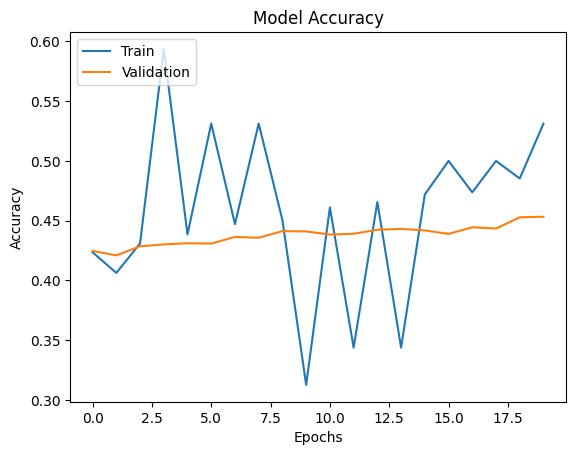

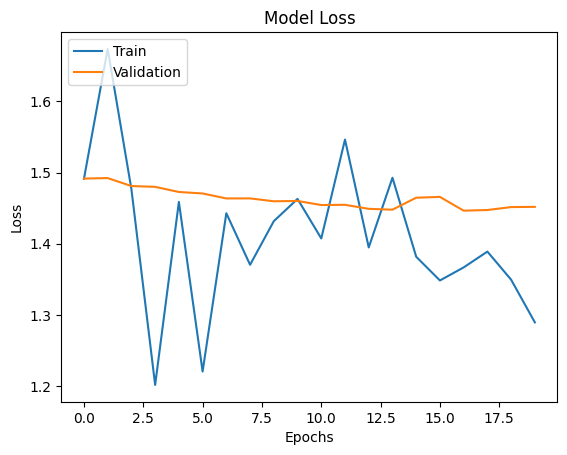

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# **Evaluate the Model Performance:**

In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // 32)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")


224/224 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.4316 - loss: 1.4863
Test Loss: 1.4924
Test Accuracy: 42.56%


## **Make Predictions:**

In [ ]:
img_path = '/content/happy.jpg'  # Use the correct path to the image you want to test


In [ ]:
import os

img_path = '/content/happy.jpg'  # Change this to your actual image path
if os.path.exists(img_path):
    print(f"The file {img_path} exists!")
else:
    print(f"The file {img_path} does not exist. Please check the path.")


The file /content/happy.jpg exists!


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Use the correct path to your test image
img_path = '/content/happy.jpg'  # Make sure this is the correct path to the image

# Load the image, resizing it to the target size (48x48)
img = image.load_img(img_path, target_size=(48, 48))

# Convert the image to a numpy array
img_array = image.img_to_array(img)

# Expand the dimensions of the image (add a batch dimension)
img_array = np.expand_dims(img_array, axis=0)

# Rescale the image (if required by your model)
img_array /= 255.0

# Predict the class of the image
prediction = model.predict(img_array)

# Get the predicted class (index of the highest probability)
predicted_class = np.argmax(prediction, axis=1)
print(f"Predicted class: {predicted_class[0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted class: 4


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Use the correct path to your test image
img_path = '/content/sad.jpg'  # Make sure this is the correct path to the image

# Load the image, resizing it to the target size (48x48)
img = image.load_img(img_path, target_size=(48, 48))

# Convert the image to a numpy array
img_array = image.img_to_array(img)

# Expand the dimensions of the image (add a batch dimension)
img_array = np.expand_dims(img_array, axis=0)

# Rescale the image (if required by your model)
img_array /= 255.0

# Predict the class of the image
prediction = model.predict(img_array)

# Get the predicted class (index of the highest probability)
predicted_class = np.argmax(prediction, axis=1)
print(f"Predicted class: {predicted_class[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted class: 3


### **classification report:**

In [ ]:
from sklearn.metrics import classification_report

# Make Predictions on the Test Dataset
test_labels = test_generator.classes  # True labels for the test set
test_preds = model.predict(test_generator, verbose=1)  # Predicted probabilities
test_preds = np.argmax(test_preds, axis=1)  # Convert to class indices

# Generate the Classification Report
report = classification_report(test_labels, test_preds, target_names=test_generator.class_indices.keys())

# Print the classification report
print(report)


225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
              precision    recall  f1-score   support

       angry       0.12      0.10      0.11       958
   disgusted       0.00      0.00      0.00       111
     fearful       0.15      0.08      0.11      1024
       happy       0.24      0.38      0.29      1774
     neutral       0.18      0.17      0.18      1233
         sad       0.18      0.14      0.16      1247
   surprised       0.12      0.11      0.11       831

    accuracy                           0.19      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.19      0.17      7178



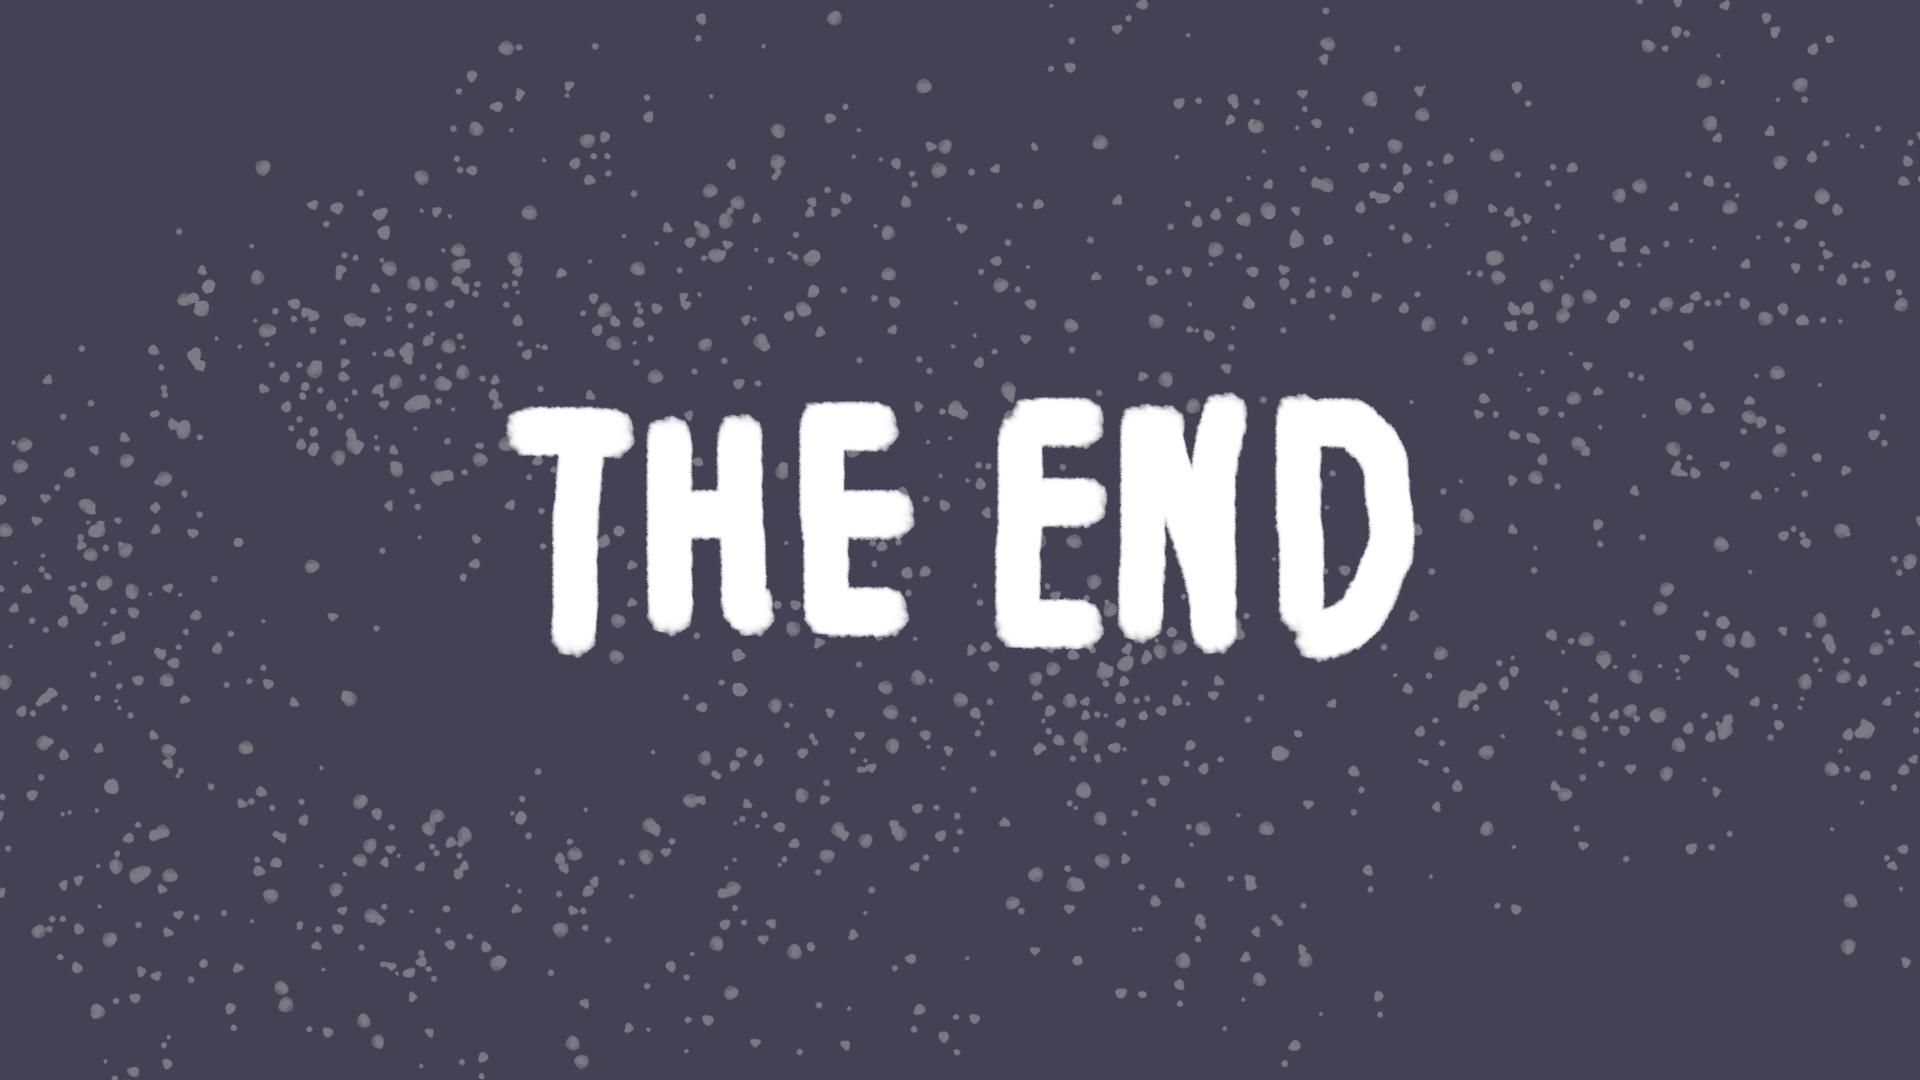

In [2]:
from IPython.display import Image

# Display an image from a file
Image(filename='/content/end.jpg')
